In [1]:
import pandas as pd
import numpy as np

In [2]:
clip_emd = pd.read_pickle('tweet_data_all_emb.pkl')

In [3]:
df_train = pd.read_pickle('train.pkl')

In [4]:
train_emd = clip_emd[clip_emd['tweet_id'].isin(df_train['tweet_id'])]

In [5]:
# train_emd

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Construction of Graph

In [7]:
from sentence_transformers import util
from sklearn import metrics
from sklearn.metrics import pairwise_distances

/root/miniconda3/envs/russiawar/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import networkx as nx
import igraph as ig

In [9]:
# similar matrix as the graph adjacency matrix
cos_mat = util.cos_sim(train_emd['clip_imgs_sum_text_embeddings'].tolist(),train_emd['clip_imgs_sum_text_embeddings'].tolist())

In [10]:
cos_copy = cos_mat.detach().cpu().numpy()

In [11]:
# choose the threshold
cos_copy[cos_copy < 0.85] = 0

In [12]:
G = nx.from_numpy_array(cos_copy)

In [40]:
nx.write_gpickle(G, "graph85.gpickle")
# G = nx.read_gpickle("test.gpickle")

In [41]:
g = ig.Graph.from_networkx(G)

# Leiden Clustering

In [42]:
import leidenalg as la

In [17]:
communities = la.find_partition(g, la.ModularityVertexPartition, n_iterations=-1)
optimizer = la.Optimiser()        
diff = 1
while diff > 0:
    diff = optimizer.optimise_partition(communities,n_iterations=-1)

In [18]:
len(communities)

142

In [19]:
dict_stats = {}
k = 0
for i in range(len(communities)):
    if not dict_stats.get(len(communities[i])):
        dict_stats[len(communities[i])] =0
    dict_stats[len(communities[i])] +=1

In [20]:
dict_stats

{1397: 1, 981: 1, 75: 1, 2: 8, 1: 131}

In [21]:
dict_com = {}
k = 0
for i in range(len(communities)):
    if (len(communities[i])>=10):
        dict_com[k] = train_emd.loc[train_emd.index[communities[i]]]
        k += 1

## Select representative nodes based on centrality measures

In [22]:
# create a new graph for each cluster
def build_graph(df_cluster, th = 0.85):
    cos_sub = util.cos_sim(df_cluster['clip_imgs_sum_text_embeddings'].tolist(),df_cluster['clip_imgs_sum_text_embeddings'].tolist()).detach().cpu().numpy()
    cos_sub[cos_sub < th] = 0
    G = nx.from_numpy_array(cos_sub)
    g = ig.Graph.from_networkx(G)
    return g

### Degree

In [23]:
def degree_centrality(g):
    degree_inx = np.argsort(g.degree())[::-1]
    return degree_inx

In [24]:
## Degree centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[degree_centrality(g)[:5]])

In [25]:
df = pd.concat(df_select)

In [26]:
df['tweet_id'].to_csv('LeidenDegree.csv')

### Pagerank

In [27]:
def pagerank_centrality(g):
    pagerank_inx = np.argsort(g.pagerank())[::-1]
    return pagerank_inx

In [28]:
## PageRank centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[pagerank_centrality(g)[:5]])

In [29]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('LeidenPageRank.csv')

### Betweenness

In [30]:
def betweenness_centrality(g):
    between_inx = np.argsort(g.betweenness())[::-1]
    return between_inx

In [31]:
## Betweenness centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[betweenness_centrality(g)[:5]])

In [32]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('LeidenBetweenness.csv')

### Closeness

In [33]:
def closeness_centrality(g):
    closeness_inx = np.argsort(g.closeness())[::-1]
    return closeness_inx

In [34]:
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[closeness_centrality(g)[:5]])

In [35]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('LeidenCloseness.csv')

### Eigenvector

In [36]:
def eigenvector_centrality(g):
    eigenvector_inx = np.argsort(g.eigenvector_centrality())[::-1]
    return eigenvector_inx

In [37]:
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[eigenvector_centrality(g)[:5]])

In [38]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('LeidenEigen.csv')

### Multi-Centrality Index  -- not working yet

=======

In [45]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [46]:
import sys
sys.path.insert(0,"/fake-news-qa/7Set-AL/MultiCentrality/")

In [47]:
import MultiCentralityIndex as MCI

In [48]:
mc = MCI.MCI()

In [53]:
cos_sub = util.cos_sim(dict_com[0]['clip_imgs_sum_text_embeddings'].tolist(),dict_com[0]['clip_imgs_sum_text_embeddings'].tolist()).detach().cpu().numpy()
cos_sub[cos_sub < 0.85] = 0
G = nx.from_numpy_array(cos_sub)
node_size=G.degree()

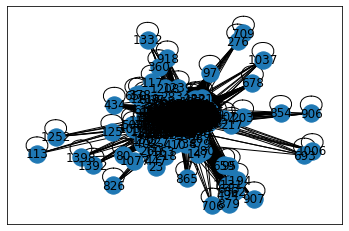

In [57]:
nx.draw_networkx(G)

In [58]:
setCentralities = ['Degree','Pagerank','Eigenvector','StructuralHoles','Closeness', 'Betweenness']

In [ ]:
mc.getMCI_PCA(G,setCetralities=setCentralities)[:10]

In [ ]:
mtxDoc = mc.getMatrixFeaturesGraph(G,setCentralities)

# Agglomerative clustering

In [43]:
from sklearn.cluster import AgglomerativeClustering

In [44]:
corpus = train_emd['processed_tweet'].tolist()

In [45]:
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.15, affinity='precomputed', linkage='average')

In [46]:
clustering_model.fit(1-cos_copy)
cluster_assignment = clustering_model.labels_

In [47]:
clustered_sentences = {}
clustered_ids = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []
        clustered_ids[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])
    clustered_ids[cluster_id].append(sentence_id)

In [48]:
communities = sorted(clustered_ids.items(), key= lambda x: len(x[1]), reverse=True) 

In [49]:
len(communities)

400

In [50]:
dict_com = {}
k = 0
for com in communities:
    if (len(com[1])>=10):
        dict_com[k] = train_emd.loc[train_emd.index[com[1]]]
        k += 1

In [51]:
## Degree centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[degree_centrality(g)[:5]])

In [52]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('AggDegree.csv')

In [53]:
## PageRank centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[pagerank_centrality(g)[:5]])

In [54]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('AggPageRank.csv')

In [55]:
## Betweenness centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[betweenness_centrality(g)[:5]])

In [56]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('AggBetweenness.csv')

In [57]:
## Closeness centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[closeness_centrality(g)[:5]])

In [58]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('AggCloseness.csv')

In [59]:
## Eigenvector centrality
df_select = []
for k in range(len(dict_com)):
    g = build_graph(dict_com[k])
    df_select.append(dict_com[k].iloc[eigenvector_centrality(g)[:5]])

In [60]:
df = pd.concat(df_select)
df['tweet_id'].to_csv('AggEigen.csv')